<a href="https://colab.research.google.com/github/syq-tju/pyCUDA/blob/main/pyCUDA_Matix_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=19d23bd0667ff7a2d53ff8d2cebd13eeff07f1ffaf468189a0c8d0557e6cc046
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda.compiler import SourceModule
import time  # 导入time模块用于CPU计时

# 定义CUDA kernel
mod = SourceModule("""
__global__ void add_vectors(float *dest, float *a, float *b)
{
    const int i = threadIdx.x + blockIdx.x * blockDim.x;
    dest[i] = a[i] + b[i];
}
""")

# 从module中获取kernel函数
add_vectors = mod.get_function("add_vectors")

# 设置随机数的数量：2^12
num_elements = 2 << 28

# 在CPU上生成随机数，赋值给a_host和b_host
a_host = np.random.rand(num_elements).astype(np.float32)
b_host = np.random.rand(num_elements).astype(np.float32)

# 开始CPU计时
cpu_start_time = time.time()
c_host = a_host + b_host  # CPU上进行向量加法
cpu_end_time = time.time()

# 显示CPU计算时间
print("CPU计算时间：", cpu_end_time - cpu_start_time, "秒")

# 分配GPU内存并复制数据
a_gpu = drv.mem_alloc(a_host.nbytes)
b_gpu = drv.mem_alloc(b_host.nbytes)
c_gpu = drv.mem_alloc(a_host.nbytes)  # c的结果数组

drv.memcpy_htod(a_gpu, a_host)
drv.memcpy_htod(b_gpu, b_host)

# 设置block和grid的大小
block_size = (256, 1, 1)
num_blocks = (num_elements + block_size[0] - 1) // block_size[0]

# 创建事件以测量GPU时间
start_event = drv.Event()
end_event = drv.Event()

# 开始GPU计时
start_event.record()
add_vectors(c_gpu, a_gpu, b_gpu, block=(block_size[0], 1, 1), grid=(num_blocks, 1))
end_event.record()
end_event.synchronize()  # 等待事件完成

# 计算并显示GPU计算时间
gpu_time = start_event.time_till(end_event) * 1e-3  # 转换为秒
print("GPU计算时间：", gpu_time, "秒")

# 将结果复制回CPU
c_host_gpu = np.empty_like(a_host)
drv.memcpy_dtoh(c_host_gpu, c_gpu)

# 比较结果
are_equal = np.allclose(c_host, c_host_gpu)
print("Are all elements equal?", are_equal)

# 显式释放GPU内存
a_gpu.free()
b_gpu.free()
c_gpu.free()


In [13]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda.compiler import SourceModule
import time

# 定义CUDA kernel进行矩阵加法
kernel_code = """
__global__ void matrix_add(float *c, const float *a, const float *b, const int width, const int height)
{
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int index = x + y * width;

    if (x < width && y < height) {
        c[index] = a[index] + b[index];
    }
}
"""

mod = SourceModule(kernel_code)
matrix_add = mod.get_function("matrix_add")

def gpu_matrix_add(matrix_add, a, b, block_size=(16, 16, 1)):
    width, height = a.shape

    a_gpu = drv.mem_alloc(a.nbytes)
    b_gpu = drv.mem_alloc(b.nbytes)
    c_gpu = drv.mem_alloc(a.nbytes)

    drv.memcpy_htod(a_gpu, a)
    drv.memcpy_htod(b_gpu, b)

    grid_size = ((width + block_size[0] - 1) // block_size[0], (height + block_size[1] - 1) // block_size[1])

    start_event = drv.Event()
    end_event = drv.Event()

    start_event.record()
    matrix_add(c_gpu, a_gpu, b_gpu, np.int32(width), np.int32(height), block=block_size, grid=grid_size)
    end_event.record()
    end_event.synchronize()

    gpu_time = start_event.time_till(end_event) * 1e-3  # 转换为秒

    c = np.empty_like(a)
    drv.memcpy_dtoh(c, c_gpu)

    a_gpu.free()
    b_gpu.free()
    c_gpu.free()

    return c, gpu_time

# 设置矩阵大小和随机矩阵
size = (2<<12, 2<<12)
a_host = np.random.rand(*size).astype(np.float32)
b_host = np.random.rand(*size).astype(np.float32)

# 开始CPU计时
cpu_start_time = time.time()
c_host = a_host + b_host  # CPU上进行向量加法
cpu_end_time = time.time()

# 显示CPU计算时间
print("CPU计算时间：", cpu_end_time - cpu_start_time, "秒")

# 使用32x16线程块
_, time_optimized_3232 = gpu_matrix_add(matrix_add, a_host, b_host, block_size=(32, 32, 1))
print("使用32x32线程块的GPU计算时间：", time_optimized_3232, "秒")
# 使用32x16线程块
_, time_optimized_3216 = gpu_matrix_add(matrix_add, a_host, b_host, block_size=(32, 16, 1))
print("使用32x16线程块的GPU计算时间：", time_optimized_3216, "秒")
# 使用16x16线程块
_, time_optimized_1616 = gpu_matrix_add(matrix_add, a_host, b_host, block_size=(16, 16, 1))
print("使用16x16线程块的GPU计算时间：", time_optimized_1616, "秒")
# 使用16x8线程块
_, time_optimized_1608 = gpu_matrix_add(matrix_add, a_host, b_host, block_size=(16, 8, 1))
print("使用16x08线程块的GPU计算时间：", time_optimized_1608, "秒")
# 使用8x8线程块
_, time_unoptimized = gpu_matrix_add(matrix_add, a_host, b_host, block_size=(8, 8, 1))
print("使用08x08线程块的GPU计算时间：", time_unoptimized, "秒")


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


CPU计算时间： 0.09925436973571777 秒
使用32x32线程块的GPU计算时间： 0.0033725121021270753 秒
使用32x16线程块的GPU计算时间： 0.0032401599884033204 秒
使用16x16线程块的GPU计算时间： 0.003235519886016846 秒
使用16x08线程块的GPU计算时间： 0.003271136045455933 秒
使用08x08线程块的GPU计算时间： 0.003280479907989502 秒


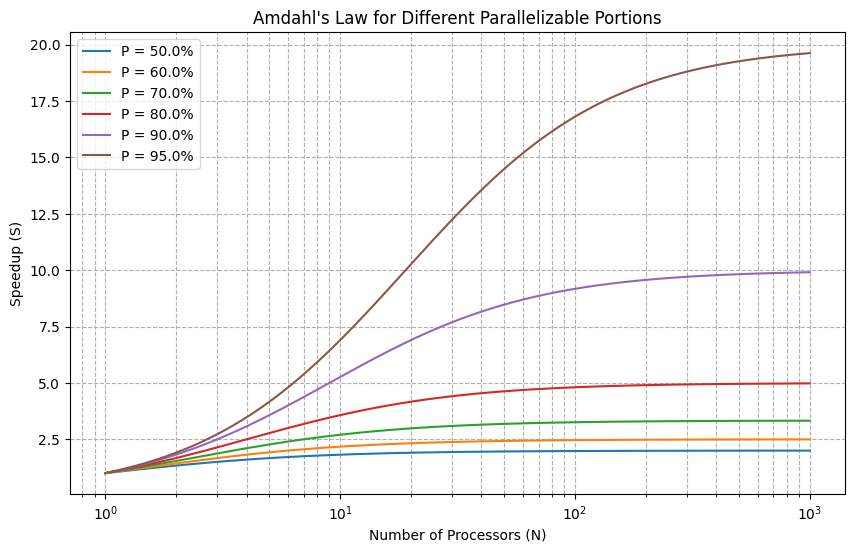

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Amdahl定律函数
def amdahl_law(P, N):
    return 1 / ((1 - P) + P / N)

# 可以并行化的部分比例集合
P_values = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# 处理器数量范围，确保起点为0.1以避免除以零的错误
N = np.logspace(0, 3, 10000)

# 绘图
plt.figure(figsize=(10, 6))

for P in P_values:
    S = amdahl_law(P, N)
    plt.semilogx(N, S, label=f'P = {P*100}%')

plt.xlabel('Number of Processors (N)')
plt.ylabel('Speedup (S)')
plt.title("Amdahl's Law for Different Parallelizable Portions")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
